In [1]:
# Print library version
import qiskit
import qiskit_aer
import qiskit_ibm_runtime

print(f"Qiskit Version: {qiskit.__version__}")
print(f"Qiskit-aer Version: {qiskit_aer.__version__}")
print(f"Qiskit-ibm-runtime Version: {qiskit_ibm_runtime.__version__}")


Qiskit Version: 1.3.2
Qiskit-aer Version: 0.16.0
Qiskit-ibm-runtime Version: 0.34.0


In [2]:
#Import all the needed library

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler

import numpy as np
from math import gcd, log2, ceil
from random import randint
from fractions import Fraction


In [3]:
# Load the ibm token if needed

def setup_token():
    print("Loading Token")
    file = open("token_loaded.txt", "r")
    token_loaded = file.read()
    file.close()
    if not token_loaded == 'True':
        print("Not Loaded")
        file = open("token.txt", "r")
        ibm_token = file.read()
        file.close()
        print("Read Token from file")
        QiskitRuntimeService.save_account( ibm_token, channel = 'ibm_quantum', overwrite=True )
        file = open("token_loaded.txt", "w")
        file.write("True")
        file.close()
        print("Loaded")
    print("Done")

setup_token()


Loading Token
Done


In [4]:
# shor number theory

def period_to_factor(N:int, a:int , r:int ):
    """
    Function to convert period into factor.
    Args:
        N (int): Number that needs to be factorized.
        a (int): Number coprime with N of witch we know the order.
        r (int): Order of the number a.
    Returns:
        Tupele(int , int): The 2 factor making-up the number N
    """

    if r % 2 == 0 and pow(a, r // 2, N) not in [-1 % N, 1]:
        p = gcd(pow(a, r // 2, N) + 1, N)
        q = gcd(pow(a, r // 2, N) - 1, N)
        return p, q
    else:
        raise Exception("Not a valid period")


In [5]:
# find a (coprime number for N)

def find_a(N:int) -> int:
    """
    Function to find a coprime number with N.
    Args:
        N (int): Number on which the coprime number will be calculated.
    Returns:
        int: The coprime number with N.
    """

    while True:
        a = randint(2, N - 1)  # Random integer in [2, N-1]
        d = gcd(a, N)
        if d == 1:
            return a  # Valid a found


In [6]:

def post_process_qpe_results(counts, N, a):
    """
    Post-processes the QPE measurement results to determine the order r.
    Args:
        counts (dict): Measurement results from the QPE circuit.
        N (int): The modulus.
        a (int): The multiplier, coprime with N.
    Returns:
        int: The order r of a modulo N.
    """

    # Find the most frequent measurement result
    most_frequent_result = max(counts, key=counts.get)

    # Convert the binary result to an integer s
    s = int(most_frequent_result, 2)

    # Get number of counting qbits
    n_counting = len(most_frequent_result)

    # Approximate the phase phi = s / 2^n
    phi = s / (2 ** n_counting)

    # Use the continued fractions algorithm to approximate phi as k/r
    fraction = Fraction(phi).limit_denominator(N)
    k, r = fraction.numerator, fraction.denominator

    # Verify if r is the order of a modulo N
    if pow(a, r, N) == 1 and r % 2 == 0 and pow(a, r // 2, N) not in [-1 % N, 1]:
        return r
    else:
        # If r is not the order, try multiples of r
        for multiple in range(2, N):
            candidate_r = r * multiple
            if pow(a, candidate_r, N) == 1:
                return candidate_r
    raise ValueError(f"Can't find r = {r}")

In [7]:
# phase estimator

def construct_U_gate(a_power, N):
    """
    Constructs the unitary gate for the operation U: |x> → |(a^power * x) mod N>.
    For x >= N, U leaves |x> unchanged.
    """
    m = ceil(log2(N))
    size = 2 ** m
    matrix = np.zeros((size, size), dtype=complex)
    for x in range(size):
        if x < N:
            y = (a_power * x) % N
        else:
            y = x
        matrix[y, x] = 1
    return UnitaryGate(matrix, label=f"U^{a_power}")

def quantum_phase_estimation(N, a, n_counting=None):
    """
    Constructs the Quantum Phase Estimation circuit for the unitary U: |x> → |a*x mod N>.
    Args:
        N (int): The modulus.
        a (int): The multiplier, coprime with N.
        n_counting (int, optional): Number of counting qubits. Defaults to 2*ceil(log2(N)) + 2.
    Returns:
        QuantumCircuit: The QPE circuit.
    """
    # Validate inputs
    if gcd(a, N) != 1:
        raise ValueError(f"{a} and {N} must be coprime.")

    m = ceil(log2(N))
    if n_counting is None:
        n_counting = 2 * m  # Increased precision

    # Quantum registers
    qr_counting = QuantumRegister(n_counting, 'counting')
    qr_eigen = QuantumRegister(m, 'eigen')
    cr_measure = ClassicalRegister(n_counting, 'measure')
    qc = QuantumCircuit(qr_counting, qr_eigen, cr_measure)

    # Initialize eigenstate to |1>
    qc.x(qr_eigen[0])

    # Apply Hadamard gates to counting qubits
    qc.h(qr_counting)

    # Apply controlled-U^(2^i) operations
    for i in range(n_counting):
        a_power = pow(a, 2**i, N)
        U_i = construct_U_gate(a_power, N)
        cU_i = U_i.control(1)
        qc.append(cU_i, [qr_counting[i]] + qr_eigen[:])

    # Apply inverse Quantum Fourier Transform
    qft_dagger = QFT(num_qubits=n_counting, inverse=True, insert_barriers=True)
    qc.append(qft_dagger, qr_counting)

    # Measure only the counting qubits
    qc.measure(qr_counting, cr_measure)

    return qc


In [8]:
def simulate_qpe(qc, shots=1024):
    """
    Simulates the QPE circuit and returns the measurement results.
    Args:
        N (int): The modulus.
        a (int): The multiplier, coprime with N.
        shots (int): Number of simulation shots.
    Returns:
        dict: Measurement counts.
    """
    simulator = AerSimulator()  # Correct backend for Qiskit Aer 0.16.0
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=shots).result()
    return result.get_counts()


In [23]:
# Example usage
# if __name__ == "__main__":
N = 21  # Example modulus
a = find_a(N)

print(f"Running QPE for N={N}, a={a}")


Running QPE for N=21, a=19


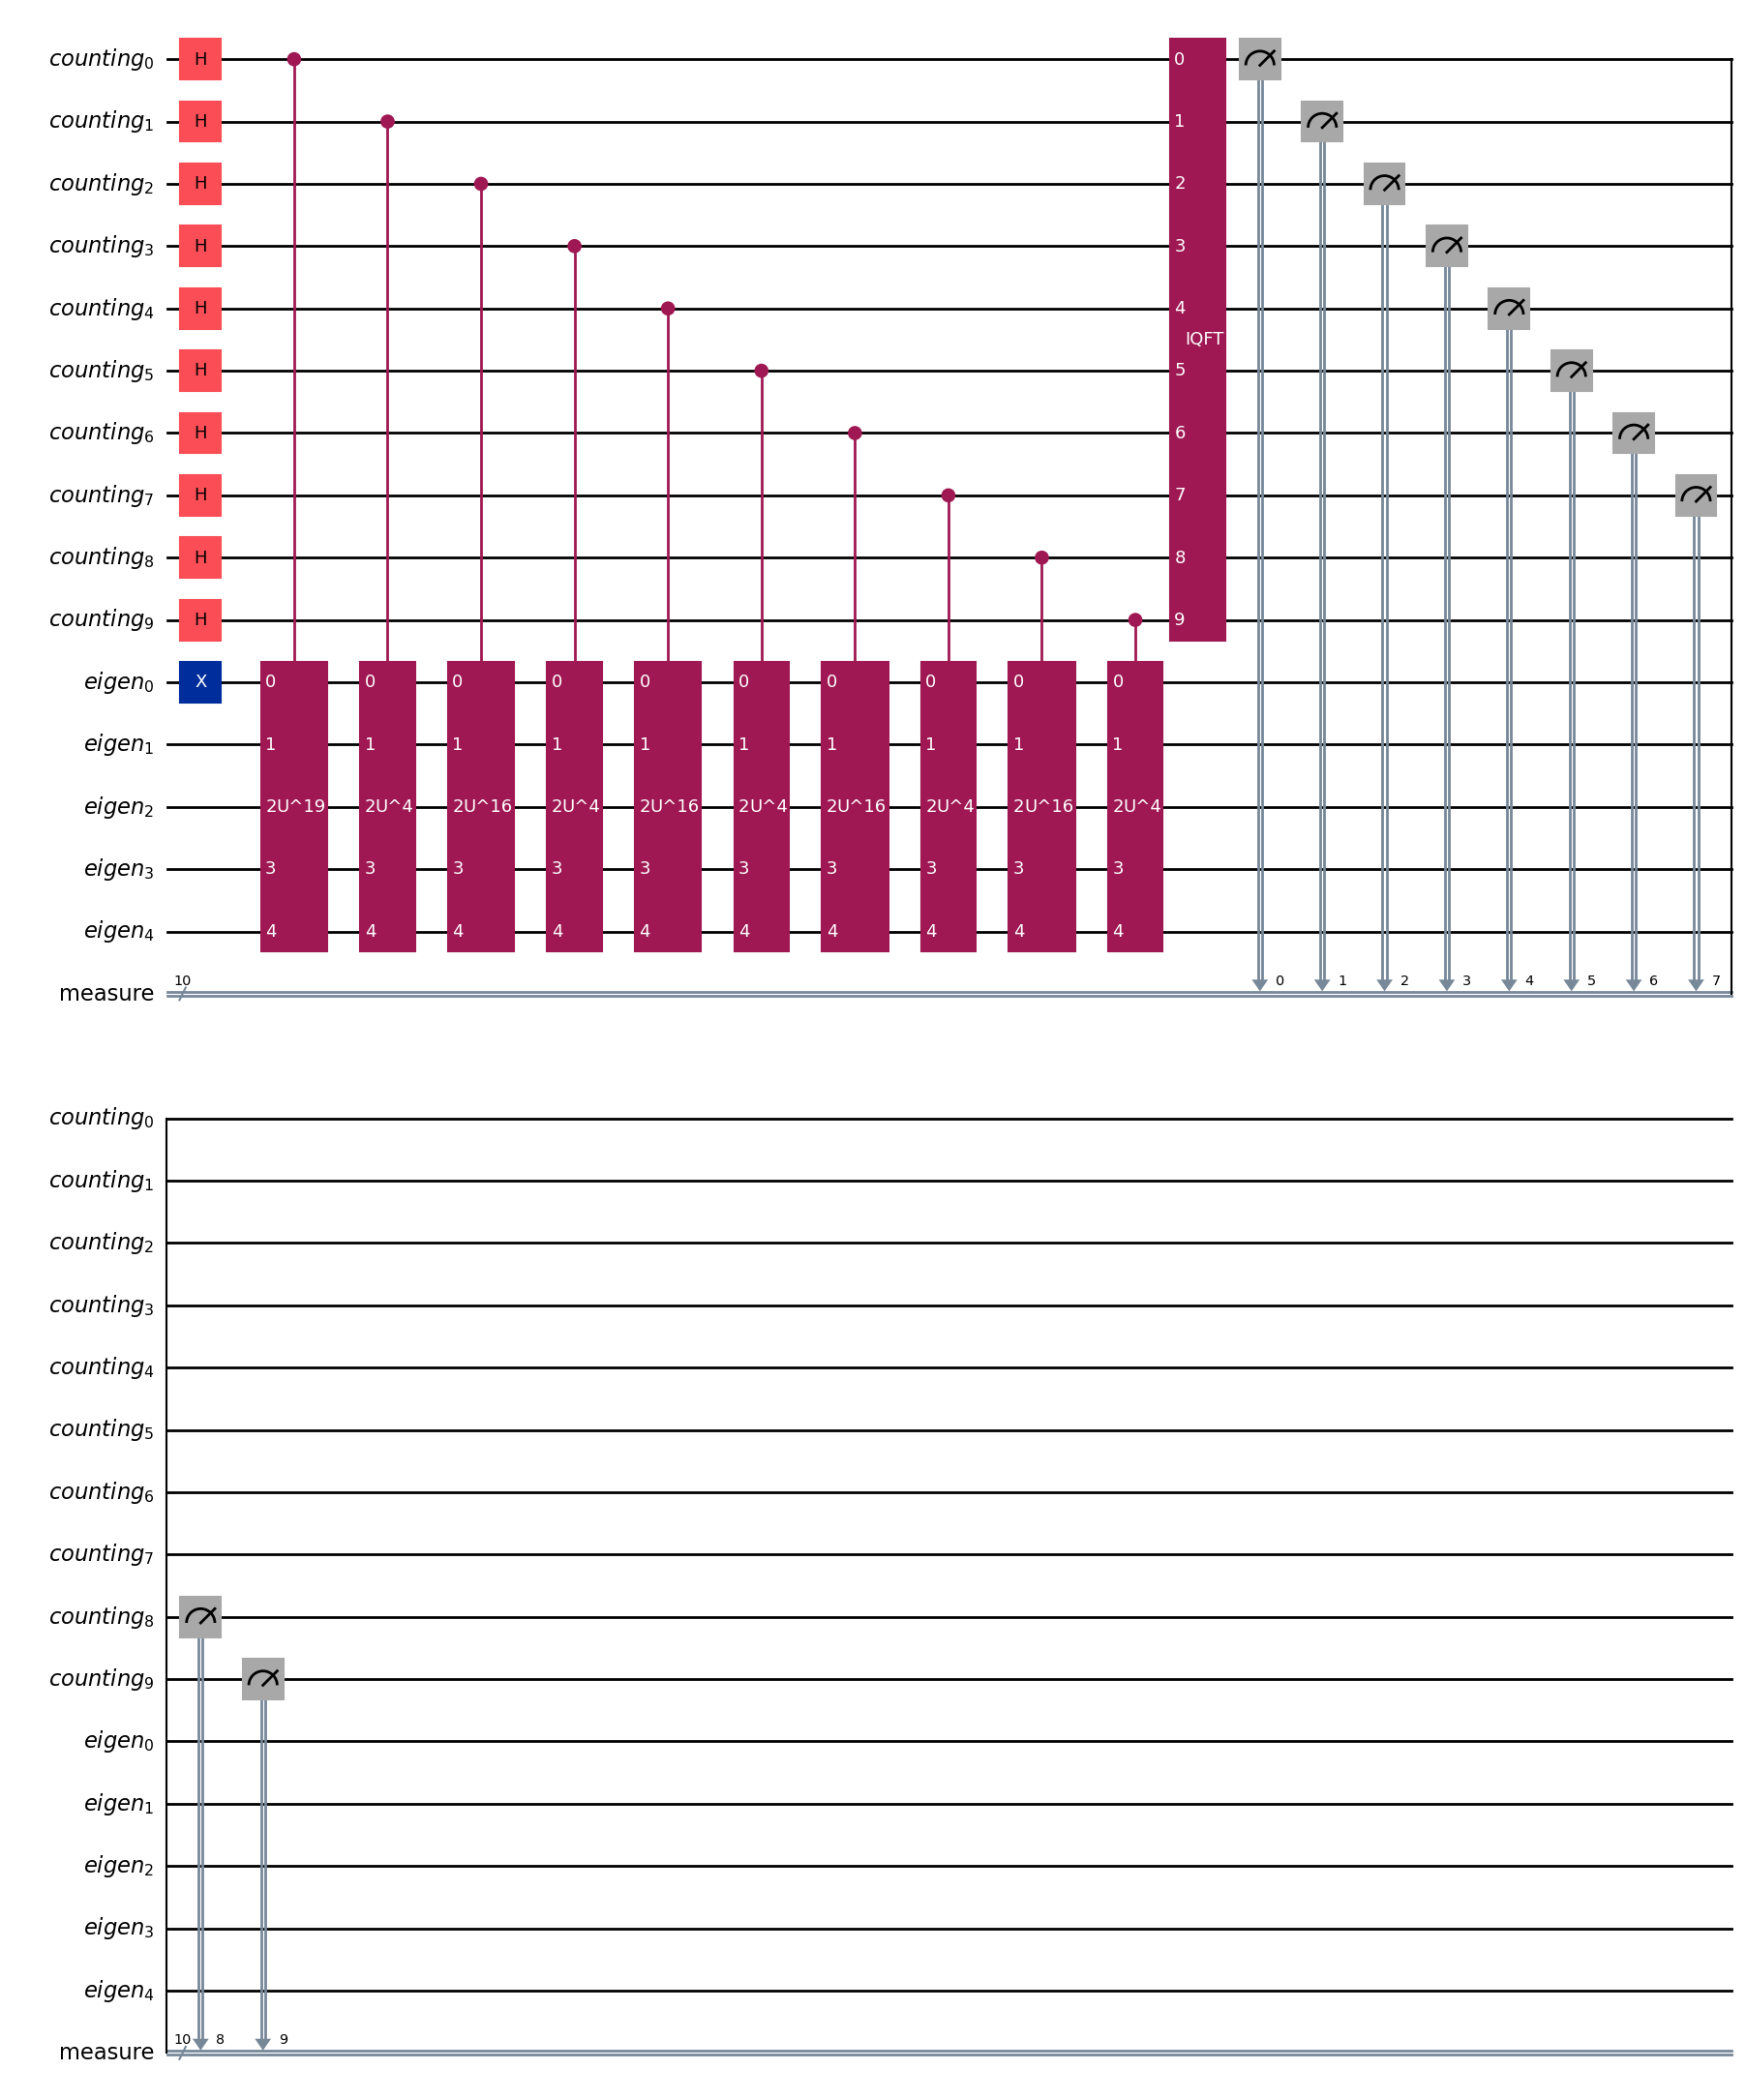

In [24]:
qc_out = quantum_phase_estimation(N, a)
qc_out.draw(output = 'mpl')


In [25]:

try:
    counts = simulate_qpe(qc_out)
    print("Measurement results:", counts)

    r = post_process_qpe_results(counts, N, a)
    print("Period:", r)

    result = period_to_factor(N, a, r)
    print(f"Result: {result}")
except:
    print("The Simulator was not able to determine the period")



Measurement results: {'0101010110': 32, '1010101010': 39, '1101011000': 1, '0010101010': 33, '0010101001': 2, '0000000000': 163, '0010101100': 7, '1000000000': 172, '1010101011': 117, '0101010101': 137, '0010101011': 96, '1010110101': 1, '1101010101': 119, '1101001010': 1, '1101010110': 29, '0011000011': 1, '1101010100': 8, '1010101100': 6, '0101010100': 11, '1101010011': 2, '0011011110': 1, '1010100101': 1, '1101100000': 1, '0101010111': 5, '0000100000': 1, '1010110000': 1, '1101010111': 4, '0010110000': 1, '0101001111': 1, '1110000000': 1, '0010100110': 1, '0010100100': 1, '0010101101': 3, '0010110100': 1, '1101011001': 1, '0101010000': 1, '1101011101': 1, '0100010000': 1, '1101001110': 1, '1101010010': 1, '0101010010': 1, '1010101110': 2, '1010101001': 3, '1010101101': 2, '0101010011': 1, '0101011000': 2, '1010100011': 1, '1010111110': 1, '1010101000': 1, '0011001001': 1, '1101111000': 1, '1101001111': 1, '0010101111': 1}
Period: 6
Result: (7, 3)


In [26]:
#transpile
service = QiskitRuntimeService()
backend = service.least_busy()

print(f'Selected backend: {backend.name} with {backend.status().pending_jobs} pending jobs')

Selected backend: ibm_brisbane with 1 pending jobs


In [27]:
transpiled_qc = transpile(
    qc_out,
    backend=backend,  # Use the backend for transpilation
    optimization_level=2 # Medium-High optimization level
)

print("Transpiled")


Transpiled


In [28]:
# get backend


sampler = Sampler(backend)
job = sampler.run([transpiled_qc], shots=1024)

print("Job ID:", job.job_id)
print("Job status:", job.status())


Job ID: <bound method BasePrimitiveJob.job_id of <RuntimeJobV2('cygdgwknrmz0008t0cvg', 'sampler')>>
Job status: QUEUED


In [29]:
# Access the PubResult objects

pub_result = job.result()[0]
quasi_dists = pub_result.data.measure.get_counts()  # Use 'meas' for measurement results

# Print the quasi-distribution
print("Quasi-probability distribution:", quasi_dists)


Quasi-probability distribution: {'0000101010': 1, '1011000110': 3, '0000001001': 1, '1101111111': 2, '1000111010': 2, '0010010111': 1, '0111010011': 2, '1111111011': 1, '1000001101': 1, '1100010100': 2, '1010011000': 2, '1111010111': 1, '1111011111': 1, '0001010011': 2, '1010000100': 3, '1011010011': 3, '1010010101': 2, '0011111111': 1, '1101100001': 2, '0000100111': 2, '0001001111': 2, '0010000000': 1, '0111000111': 2, '0111000100': 2, '0101010100': 5, '1110111110': 3, '0010111100': 2, '1100010110': 1, '0110110010': 1, '1101011110': 2, '1110011011': 3, '1010111000': 2, '1100110100': 1, '0111001000': 1, '1100111011': 1, '1001000101': 1, '0000010001': 2, '1110001111': 2, '1101100101': 1, '1101000000': 2, '0111100000': 2, '0101111000': 1, '0000001000': 1, '1001110010': 3, '0110001011': 2, '1110100000': 3, '0110001000': 2, '1111010110': 2, '1001001000': 1, '1010011001': 2, '0100111010': 3, '0011000011': 2, '1101011001': 1, '0110101111': 1, '0101110110': 2, '0111110010': 1, '1010001111': 3

In [30]:
r = post_process_qpe_results(quasi_dists, N, a)
print("Period:", r)

result = period_to_factor(N, a, r)
print(f"Result: {result}")

Period: 102
Result: (7, 3)
